## 2. Kreuzvalidierung und Modellselektion

Bei der Methode der Kreuzvalidierung wird der zufällige Split in Trainings- und Testdatensatz aus Aufgabe 1 mehrere Male wiederholt und der Durchschnitt über mehrere Splits berechnet, um eine genauere Schätzung der wirklichen Treffergenauigkeit zu erhalten. Scikit Learn stellt dafür bereits eine vordefinierte Methode zur Verfügung: sklearn.model_selection. Die Methode verwendet die Iteratorsyntax von Python, Beispiele zur Verwendung finden Sie in der Dokumentation dieser Methode. ShuffleSplit() erzeugt einen Satz von permutierten Indizes von Trainings- und Testdaten.

### a.)
Erzeugen Sie zunächst 3 Sätze und trainieren Sie für jeden Satz eine SVM mit und und geben Sie jeweils die Treffergenauigkeit für Trainings- und Testdatensatz aus. Die Ergebnisse sollten ähnlich wie in Aufgabe 1b aussehen

In [2]:

from sklearn.datasets import load_digits
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVC

x, y = load_digits(return_X_y=True, as_frame=True)
x, y = x.values, y.values

cv_splitter = ShuffleSplit(n_splits=3, train_size=.8)
idx = 1
for train_index, test_index in cv_splitter.split(x, y):
    svm_clf = SVC(C=1e-1, gamma=1e-3)
    svm_clf.fit(x[train_index], y[train_index])
    print(f"Fold {idx}----------------------------------")
    print(f"Train-Score: {svm_clf.score(x[train_index], y[train_index])}")
    print(f"Test-Score: {svm_clf.score(x[test_index], y[test_index])}")
    idx += 1

Fold 1----------------------------------
Train-Score: 0.9784272790535838
Test-Score: 0.9638888888888889
Fold 2----------------------------------
Train-Score: 0.9832985386221295
Test-Score: 0.9527777777777777
Fold 3----------------------------------
Train-Score: 0.9805149617258176
Test-Score: 0.95


### b.)
Statt wie in 2a von Hand vorzugehen gibt es in Scikit Learn die bereits vordefinierte Methode sklearn.model_selection.cross_val_score(). Wiederholen Sie Ihr Experiment aus Aufgabe 2a mit 10 Zufallssplits und geben Sie jeweils die Treffergenauigkeit auf dem Testdatensatz aus. Berechnen Sie die mittlere Treffergenauigkeit (die Kreuzvalidierungsgenauigkeit) und die Standardabweichung des Mittelwerts.


In [3]:
from sklearn.model_selection import cross_val_score
import numpy as np

cv_score = cross_val_score(SVC(C=1e-1, gamma=1e-3), x, y, cv=10)

print(f"Mean Score: {np.mean(cv_score)}")
print(f"Standard Deviation: {np.std(cv_score)}")

Mean Score: 0.9482247051520794
Standard Deviation: 0.029830757364501834


### c.)
Mithilfe der Kreuzvalidierungsgenauigkeit können die optimalen- und -Parameter der SVM automatisch gefunden werden. Dieser Vorgang heißt Modellselektion. Man führt zu diesem Zweck eine Gittersuche durch: zunächst wird ein Satz von Werten für und festgelegt. Für alle Wertepaare wird die Kreuzvalidierungsgenauigkeit bestimmt und dann die Parameter gewählt, die die höchste Treffergenauigkeit erzielen. Finden Sie auf diese Weise für den besten Gammawert aus einem Satz von 10 logarithmisch skalierten Gammawerten, erzeugt mit
 ```{python}
import numpy as np
gammas = np.logspace(-7, -1, 10)
 ```
Verwenden Sie dazu eine Trainings- und Testdatensatzgröße von 500 und 5 Splits (s. Dokumentation von ShuffleSplit) und speichern Sie die Treffergenauigkeit auf dem Trainings- und Testdatensatz für jeden Gammawert und Split. Plotten Sie die Treffergenauigkeitskurve für jeden Split mit dem Gammawert als Abszisse in einem gemeinsamen Diagramm, jeweils für die Trainings- und die Testdaten. Diese Kurven werden Validierungskurven genannt (s.u.). Für welche Gammawerte erhalten Sie Underfitting, für welche Overfitting? Wo liegt der optimale Gammawert?

In [4]:
from sklearn.model_selection import ShuffleSplit
import numpy as np
import pandas as pd

cv_splitter = ShuffleSplit(n_splits=5, test_size=500, train_size=500, random_state=42)

gammas = np.logspace(-7, -1, 10)

cv_results = []

for gamma in gammas:
    cv_idx = 1
    for train_index, test_index in cv_splitter.split(x, y):
        svm_clf = SVC(gamma=gamma)
        svm_clf.fit(x[train_index], y[train_index])
        cv_results.append({
            "CV_Fold": cv_idx,
            "gamma": gamma,
            "CV_Score": svm_clf.score(x[test_index], y[test_index])
        })
        cv_idx += 1

cv_results = pd.DataFrame(cv_results)

[]

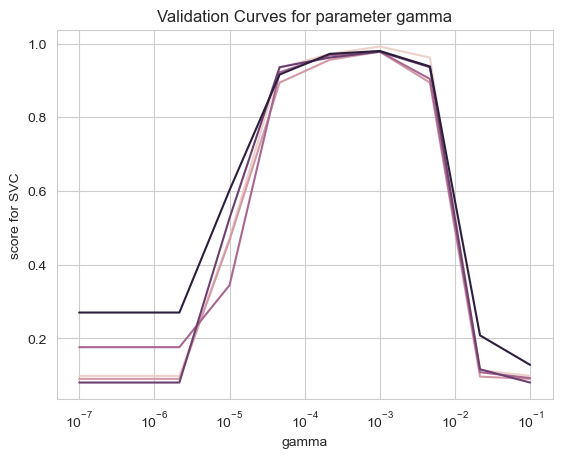

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.lineplot(data=cv_results, x="gamma", y="CV_Score", hue="CV_Fold", legend=None)
ax.set_xlabel("gamma")
ax.set_ylabel("score for SVC")
ax.set_title("Validation Curves for parameter gamma")
ax.set_xscale("log")
plt.plot()

### d.)
Die Gittersuche lässt sich ebenfalls automatisieren mit sklearn.model_selection. GridSearchCV(). Wir erzeugen dazu ein Gitter aus Wertepaaren für und mit dem Dictionary
```
svc_params = {
    'C': np.logspace(-1, 2, 4),
    'gamma': np.logspace(-4, 0, 5),
}
```
Dieses Gitter kann direkt an GridSearchCV() als Argument param_grid übergeben werden. Da diese Prozedur sehr zeitaufwendig ist, verkleinern wie den Datensatz auf die ersten 500 Beispiele. Führen Sie für diesen verkleinerten Datensatz eine Gittersuche mithilfe von GridSearchCV() und jeweils 3 Splits (Parameter cv) durch. Den besten Parametersatz erhalten Sie mit GridSearchCV().best_params_, die höchste Treffergenauigkeit mit GridSearchCV().best_score_. Ausführliche Informationen zu jedem Parameterwertepaar stehen in dem Dictionary GridSearchCV().cv_results_. Nach der Gittersuche führt GridSearchCV() noch ein Training auf dem gesamten Datensatz mit den besten Parametern durch, so dass die resultierende Maschine sofort eingesetzt werden kann. Testen Sie diese Maschine auf den übriggebliebenen Daten.

In [7]:
from sklearn.model_selection import GridSearchCV

val_x = x[0:500]
val_y = y[0:500]

param_grid = {
    "C": np.logspace(-1, 2, 4),
    "gamma": np.logspace(-4, 0, 5)
}

grid_cv = GridSearchCV(SVC(), param_grid, cv=3, verbose=2)
grid_cv.fit(val_x, val_y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END ................................C=0.1, gamma=0.0001; total time=   0.0s
[CV] END ................................C=0.1, gamma=0.0001; total time=   0.0s
[CV] END ................................C=0.1, gamma=0.0001; total time=   0.0s
[CV] END .................................C=0.1, gamma=0.001; total time=   0.0s
[CV] END .................................C=0.1, gamma=0.001; total time=   0.0s
[CV] END .................................C=0.1, gamma=0.001; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': array([  0.1,   1. ,  10. , 100. ]),
                         'gamma': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])},
             verbose=2)

In [8]:
pd.DataFrame(grid_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.021846,0.003666,0.013381,0.002469,0.1,0.0001,"{'C': 0.1, 'gamma': 0.0001}",0.269461,0.365269,0.301205,0.311978,0.039849,11
1,0.015933,0.000581,0.009089,0.000782,0.1,0.001,"{'C': 0.1, 'gamma': 0.001}",0.820359,0.898204,0.837349,0.851971,0.033419,7
2,0.014429,0.001082,0.009358,0.002657,0.1,0.01,"{'C': 0.1, 'gamma': 0.01}",0.107784,0.173653,0.102410,0.127949,0.032392,16
3,0.025632,0.000420,0.013404,0.002563,0.1,0.1,"{'C': 0.1, 'gamma': 0.1}",0.107784,0.107784,0.102410,0.105993,0.002534,17
4,0.026817,0.002573,0.014378,0.000745,0.1,1.0,"{'C': 0.1, 'gamma': 1.0}",0.107784,0.203593,0.102410,0.137929,0.046483,12
5,0.009895,0.000692,0.009299,0.000785,1.0,0.0001,"{'C': 1.0, 'gamma': 0.0001}",0.898204,0.958084,0.831325,0.895871,0.051775,6
6,0.013169,0.001219,0.007888,0.000658,1.0,0.001,"{'C': 1.0, 'gamma': 0.001}",0.916168,0.994012,0.849398,0.919859,0.059096,4
7,0.017875,0.001631,0.010652,0.001043,1.0,0.01,"{'C': 1.0, 'gamma': 0.01}",0.604790,0.706587,0.536145,0.615841,0.070020,10
8,0.017087,0.000361,0.008471,0.000538,1.0,0.1,"{'C': 1.0, 'gamma': 0.1}",0.107784,0.107784,0.102410,0.105993,0.002534,17
9,0.020356,0.000855,0.011380,0.001062,1.0,1.0,"{'C': 1.0, 'gamma': 1.0}",0.107784,0.203593,0.102410,0.137929,0.046483,12


In [9]:
grid_cv.score(x[501:], y[501:])

0.941358024691358

In [11]:
grid_cv.best_params_

{'C': 100.0, 'gamma': 0.0001}